# JEC profile plots

Coffea 0.7.1 https://github.com/cms-jet/CoffeaJERC/blob/master/genL2L3.ipynb 

and [nanoevents.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/nanoevents.ipynb) to illustrate profile plots

In [1]:
import awkward as ak
import numpy as np
import time
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
fname = "root://cmsxrootd.fnal.gov//store/mc/RunIISummer19UL17NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/JMECustomTuples_106X_mc2017_realistic_v6-v1/280000/0CEC4EFC-9CBD-B64C-8721-29D0CBB1F0AA.root"

events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

/home/cms.mmorris/coffeajerc/CoffeaJERC/coffea-jerc/lib/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,


In [2]:
from coffea import processor, hist
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        dr_axis = hist.Bin("dr", r"$\delta (\eta)$", 20, 0., 1)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        r_axis = hist.Bin("r", "RECO / GEN response", 200, 0, 5)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'r_pt_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptvm':hist.Hist("Counts", dataset_axis, pt_axis, m_axis, r_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        output['cutflow']['all events'] += len(events)
        #print(len(events))
        
        selectedEvents = events[
            (ak.num(events.Jet) > 2)
        ]

        #leading jet
        #print(selectedEvents.Jet[:,0])
        #leading two jets
        jet = selectedEvents.Jet[:,0:2]
        jet = ak.flatten(jet)
        #only with genmatch
        jet = jet[~ak.is_none(jet.matched_gen)]
        #only with good deltaR match
        jet = jet[jet.delta_r(jet.matched_gen)<0.2]
        
        ptresponse = jet.pt/jet.matched_gen.pt
        
        output['dr'].fill(dataset=selectedEvents.metadata["dataset"],
                            dr=jet.delta_r(jet.matched_gen))
        output['pt'].fill(dataset=selectedEvents.metadata["dataset"],
                            pt=jet.pt)
        output['eta'].fill(dataset=selectedEvents.metadata["dataset"], 
                                 eta=jet.eta)
        output['r_pt_ptveta'].fill( dataset=selectedEvents.metadata["dataset"], pt=jet.pt, eta=jet.eta, r=ptresponse)
        
        return output

    def postprocess(self, accumulator):
        return accumulator
   

In [3]:
samples = {
    "QCD": [fname]
}
tstart = time.time() 
output = processor.run_uproot_job(
    samples,
    "Events",
    FancyJECL2L3Processor(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
)
elapsed = time.time() - tstart
print(output)
print("Events/s:", output['cutflow']['all events']/elapsed)

/home/cms.mmorris/coffeajerc/CoffeaJERC/coffea-jerc/lib/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,



{'pt': <Hist (dataset,pt) instance at 0x7f6e4d730cc0>, 'eta': <Hist (dataset,eta) instance at 0x7f6e4d730d30>, 'dr': <Hist (dataset,dr) instance at 0x7f6e4d730c88>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6e4cbb4ba8>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6e4cbb4828>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f6e4cbb4748>, 'cutflow': defaultdict(<class 'int'>, {'all events': 626100})}
Events/s: 22049.368940829772


In [4]:
print("\n output: \n")
print(output)
print("\nhistogram and dictionary names: \n")
for key in output.keys():
    print(key)


 output: 

{'pt': <Hist (dataset,pt) instance at 0x7f6e4d730cc0>, 'eta': <Hist (dataset,eta) instance at 0x7f6e4d730d30>, 'dr': <Hist (dataset,dr) instance at 0x7f6e4d730c88>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6e4cbb4ba8>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6e4cbb4828>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f6e4cbb4748>, 'cutflow': defaultdict(<class 'int'>, {'all events': 626100})}

histogram and dictionary names: 

pt
eta
dr
r_pt_ptveta
r_m_ptveta
r_m_ptvm
cutflow


In [5]:
import mplhep as hep
import matplotlib.pyplot as plt

In [6]:
EtaBins = output['r_pt_ptveta'].axis('eta')
EtaBinNums = len(output['eta'].values()[('QCD',)])

PtBins = output['r_pt_ptveta'].axis('pt')
PtBinNums = len(output['pt'].values()[('QCD',)])

## Plot $\eta$

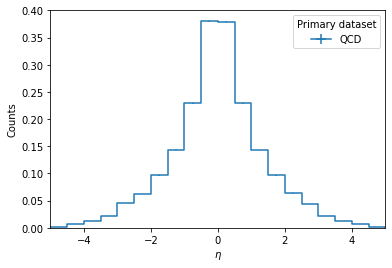

In [7]:
ax = hist.plotgrid(output['eta'], overlay="dataset", stack=False, density=True)


## Plot $p_{T}$

In [8]:
 # your code here

 ## Plot JER and response correction for $\eta$

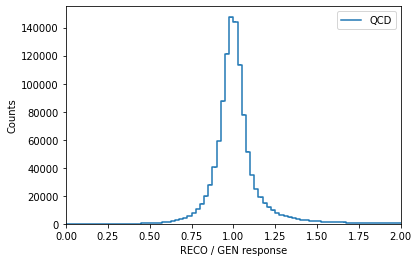

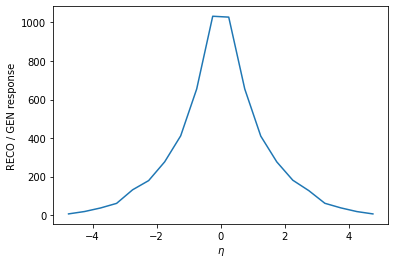

In [9]:
# jet energy response
fig, ax = plt.subplots(1, 1)

h_jer = output['r_pt_ptveta'].sum('dataset').sum('eta').sum('pt')
ax = hist.plot1d(h_jer)
ax.set_xlim(0,2)
plt.legend(['QCD'])
plt.show()




# jet energy response vs eta

fig, ax = plt.subplots(1, 1)

h = output['r_pt_ptveta'].sum('dataset').sum('pt')

xaxis='eta'
yaxis='r'
xaxis = h.axis(xaxis)
yaxis = h.axis(yaxis)
xoverflow='none'
xedges = xaxis.edges(overflow=xoverflow)
xcenters = xaxis.centers(overflow=xoverflow)



ax.plot(xcenters, np.average(h.values()[()], axis=1))
ax.set_xlabel(xaxis.label)
ax.set_ylabel(yaxis.label)





# your code here








plt.show()

 ## Bonus: Plot  response correction for $p_{T}$

In [10]:
# your code here

 ## Bonus: Plot JEC for separate $\eta$ and $p_{T}$ Bins

In [11]:

print('\n eta bins:\n')
for i in range(EtaBinNums):
    print('Bin #' + str(i) + ': '+ str(EtaBins[i]))
    
print('\n pt bins:\n')
for i in range(PtBinNums):
    print('Bin #' + str(i) + ': '+ str(PtBins[i]))


 eta bins:

Bin #0: (-inf, -5)
Bin #1: [-5, -4.5)
Bin #2: [-4.5, -4)
Bin #3: [-4, -3.5)
Bin #4: [-3.5, -3)
Bin #5: [-3, -2.5)
Bin #6: [-2.5, -2)
Bin #7: [-2, -1.5)
Bin #8: [-1.5, -1)
Bin #9: [-1, -0.5)
Bin #10: [-0.5, 0)
Bin #11: [0, 0.5)
Bin #12: [0.5, 1)
Bin #13: [1, 1.5)
Bin #14: [1.5, 2)
Bin #15: [2, 2.5)
Bin #16: [2.5, 3)
Bin #17: [3, 3.5)
Bin #18: [3.5, 4)
Bin #19: [4, 4.5)

 pt bins:

Bin #0: (-inf, 5)
Bin #1: [5, 10)
Bin #2: [10, 15)
Bin #3: [15, 20)
Bin #4: [20, 25)
Bin #5: [25, 30)
Bin #6: [30, 35)
Bin #7: [35, 40)
Bin #8: [40, 45)
Bin #9: [45, 50)
Bin #10: [50, 60)
Bin #11: [60, 70)
Bin #12: [70, 80)
Bin #13: [80, 90)
Bin #14: [90, 100)
Bin #15: [100, 120)
Bin #16: [120, 140)
Bin #17: [140, 160)
Bin #18: [160, 180)
Bin #19: [180, 200)
Bin #20: [200, 250)
Bin #21: [250, 300)
Bin #22: [300, 350)
Bin #23: [350, 400)
Bin #24: [400, 450)
Bin #25: [450, 500)
Bin #26: [500, 600)
Bin #27: [600, 700)
Bin #28: [700, 800)
Bin #29: [800, 900)
Bin #30: [900, 1000)
Bin #31: [1000, 1500)
